# Info

build with help from chat gpt: https://chatgpt.com/c/6877d186-2e5c-8007-91e0-4d0b4296e470

# TODO

- further stategieze training
  - don't use all or random, look into using particular cases
- what is exactly ment with normalizing, can we improve on that, or use log instead of linear. See the normalization that is suggested by chatgpt
- 
  

# Multiple targets not clean

currently I don't think this is working well, training is clearly to fast

## Building Training Samples

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
# Load your full dataset (SURFRAD + RADFLUX output)
# Dimensions: time, variable


In [3]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

In [72]:
p2f = pl.Path('/home/hagen/data/grad/surfrad_avg10min/radflux_nc/v1.0/tbl/2018/')

In [73]:
ds = xr.open_mfdataset(p2f.glob('*'))

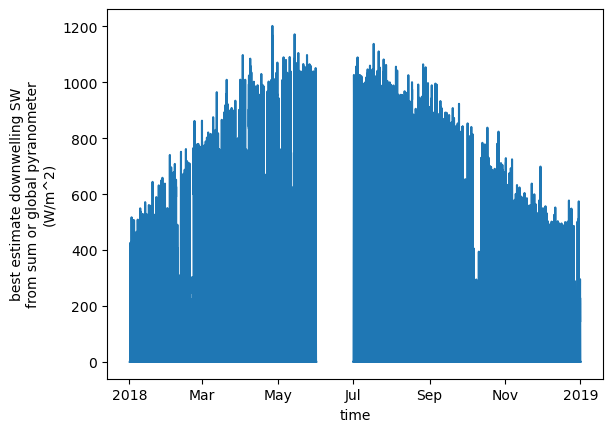

In [78]:
ds.shortwave_down_best_estimate.plot()

In [79]:
ds = ds.sel(time = slice(pd.to_datetime('20180101'),pd.to_datetime('20180301')))

In [173]:
input_vars = ['distance_from_sun',
 'shortwave_down_best_estimate',
 'longwave_down',
 'shortwave_up',
 'longwave_up',
 'shortwave_diffuse_down_best_estimate',
 'shortwave_direct',
 'temp_air',
 'rh',
 'wind_speed']

In [174]:
from numpy.lib.stride_tricks import sliding_window_view

In [175]:
target_vars = ['shortwave_down_clear_sky_estimate',
 'longwave_down_clear_sky_estimate',
 'shortwave_up_clear_sky_estimate',
 'longwave_up_clear_sky_estimate',
 'shortwave_diffuse_down_clear_sky_estimate',
 'shortwave_direct_clear_sky_estimate',
 'flag_clear_sky',
 'flag_tau',
 'flag_tlim',
 'sky_cover_longwave',
 'sky_cover_shortwave',
 'cloud_OD',
 'cloud_transmissivity',
 'cloud_ice_temp_limit',
 'sky_brightness_temp',
 'cloud_radiating_temp',
 'cloud_radiating_height',
 'longwave_emissivity_clear_sky',
 ]

In [176]:
target_names = target_vars
monitored_index = 0  # COD

In [177]:
# Parameters
window_days = 1 #30
dt_minutes = 10
samples_per_year = 24 * (60 // dt_minutes) * 365  # ~35000 per year

window_len = window_days * 24 * (60 // dt_minutes)  # number of time steps in window

In [178]:
# Select and stack inputs
X_raw = ds[input_vars].to_array().transpose('time', 'variable').values  # shape (time, features)
y_raw = ds[target_vars].to_array().transpose('time', 'variable').values                                  # shape (time,)

In [179]:
y_raw.shape

(8455, 18)

In [180]:
# Step 1: sliding window over time axis
X_win = sliding_window_view(X_raw, window_shape=(window_len, X_raw.shape[1]))  # shape: (n_samples, 1, window_len, n_features)
X_win = X_win.squeeze(axis=1)  # Now shape = (n_samples, window_len, n_features)

In [181]:
# Step 2: align target
y_win = y_raw[window_len - 1:]  # same number of samples as X_win

# Step 3: mask out NaNs
mask = ~np.isnan(X_win).any(axis=(1, 2)) & ~np.isnan(y_win).any(axis = 1)
X_win = X_win[mask]
y_win = y_win[mask]

In [182]:
if 0:
    # save
    np.savez_compressed("radflux_data.npz", X=X_win, y=y_win)
    # load
    data = np.load("radflux_data.npz")
    X_win = data['X']
    y_win = data['y']


In [183]:
import torch.nn.functional as F


In [184]:
target_vars

['shortwave_down_clear_sky_estimate',
 'longwave_down_clear_sky_estimate',
 'shortwave_up_clear_sky_estimate',
 'longwave_up_clear_sky_estimate',
 'shortwave_diffuse_down_clear_sky_estimate',
 'shortwave_direct_clear_sky_estimate',
 'flag_clear_sky',
 'flag_tau',
 'flag_tlim',
 'sky_cover_longwave',
 'sky_cover_shortwave',
 'cloud_OD',
 'cloud_transmissivity',
 'cloud_ice_temp_limit',
 'sky_brightness_temp',
 'cloud_radiating_temp',
 'cloud_radiating_height',
 'longwave_emissivity_clear_sky']

In [185]:
target_vars[11]

'cloud_OD'

In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

# -----------------------------
# Configuration
# -----------------------------
BATCH_SIZE = 64
NUM_EPOCHS = 100
PATIENCE = 10
LEARNING_RATE = 1e-3
TARGET_NAMES = target_vars#[f"target_{i}" for i in range(18)]  # Replace with actual names
MONITORED_INDEX = 11  # Index of the target to monitor for early stopping

# -----------------------------
# Dataset Definition
# -----------------------------
class RADFLUXDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -----------------------------
# Model Definition
# -----------------------------
class CNNLSTMModel(nn.Module):
    def __init__(self, n_features, time_steps, n_targets, conv_out_channels=64, lstm_hidden=64):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=conv_out_channels, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)
        self.lstm = nn.LSTM(input_size=conv_out_channels, hidden_size=lstm_hidden, num_layers=1, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, n_targets)

    def forward(self, x):
        x = x.permute(0, 2, 1)     # (batch, features, time)
        x = self.relu(self.conv1(x))
        x = self.pool(x)           # (batch, conv_out, time//4)
        x = x.permute(0, 2, 1)     # (batch, time//4, conv_out)
        x, _ = self.lstm(x)
        x = x[:, -1, :]            # last time step
        return self.fc(x)          # (batch, n_targets)

# -----------------------------
# RMSE Function
# -----------------------------
def compute_rmse(preds, targets):
    mse = F.mse_loss(preds, targets, reduction='none')  # (batch, n_targets)
    rmse = torch.sqrt(mse.mean(dim=0))                  # (n_targets,)
    return rmse.cpu().numpy()

# -----------------------------
# Load Data
# -----------------------------
# data = np.load("radflux_data.npz")
# X_win = data['X']  # shape: (samples, time_steps, features)
# y_win = data['y']  # shape: (samples, n_targets)

n_samples, time_steps, n_features = X_win.shape
n_targets = y_win.shape[1]

# -----------------------------
# Data Preparation
# -----------------------------
dataset = RADFLUXDataset(X_win, y_win)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# Model, Loss, Optimizer
# -----------------------------
model = CNNLSTMModel(n_features, time_steps, n_targets)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -----------------------------
# Training Loop with Early Stopping
# -----------------------------
best_monitored_rmse = float('inf')
wait = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_rmse_total = np.zeros(n_targets)
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_preds = model(X_val)
            val_rmse_total += compute_rmse(val_preds, y_val)

    val_rmse_avg = val_rmse_total / len(val_loader)
    monitored_rmse = val_rmse_avg[MONITORED_INDEX]

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val RMSE: {dict(zip(TARGET_NAMES, val_rmse_avg.round(4)))}")

    if monitored_rmse < best_monitored_rmse:
        best_monitored_rmse = monitored_rmse
        wait = 0
        torch.save(model.state_dict(), "best_radflux_model_mt.pt")
        print(f"✅ New best {TARGET_NAMES[MONITORED_INDEX]} RMSE: {monitored_rmse:.4f}")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"⏹ Early stopping triggered. Best {TARGET_NAMES[MONITORED_INDEX]} RMSE: {best_monitored_rmse:.4f}")
            break


Epoch 1/100 | Train Loss: 40485.4336 | Val RMSE: {'shortwave_down_clear_sky_estimate': np.float64(238.4098), 'longwave_down_clear_sky_estimate': np.float64(220.119), 'shortwave_up_clear_sky_estimate': np.float64(91.0473), 'longwave_up_clear_sky_estimate': np.float64(315.137), 'shortwave_diffuse_down_clear_sky_estimate': np.float64(46.3389), 'shortwave_direct_clear_sky_estimate': np.float64(191.5805), 'flag_clear_sky': np.float64(1.7455), 'flag_tau': np.float64(2.0028), 'flag_tlim': np.float64(0.6825), 'sky_cover_longwave': np.float64(0.1575), 'sky_cover_shortwave': np.float64(1.2727), 'cloud_OD': np.float64(13.1616), 'cloud_transmissivity': np.float64(0.2625), 'cloud_ice_temp_limit': np.float64(268.2899), 'sky_brightness_temp': np.float64(263.1038), 'cloud_radiating_temp': np.float64(249.7225), 'cloud_radiating_height': np.float64(3.4107), 'longwave_emissivity_clear_sky': np.float64(0.5666)}
✅ New best cloud_OD RMSE: 13.1616
Epoch 2/100 | Train Loss: 40461.3203 | Val RMSE: {'shortwave_

## apply the model to some data

In [189]:
# load the model
# Make sure model architecture matches what was trained
model = CNNLSTMModel(n_features=X_new.shape[2], time_steps=X_new.shape[1], n_targets=18)
model.load_state_dict(torch.load("best_radflux_model_mt.pt"))
model.eval()  # Important: sets dropout and batchnorm to eval mode

NameError: name 'X_new' is not defined

# Single target

## Building Training Samples

In [162]:
import xarray as xr
import numpy as np
import pandas as pd

In [163]:
# Load your full dataset (SURFRAD + RADFLUX output)
# Dimensions: time, variable


In [164]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

In [72]:
p2f = pl.Path('/home/hagen/data/grad/surfrad_avg10min/radflux_nc/v1.0/tbl/2018/')

In [73]:
ds = xr.open_mfdataset(p2f.glob('*'))

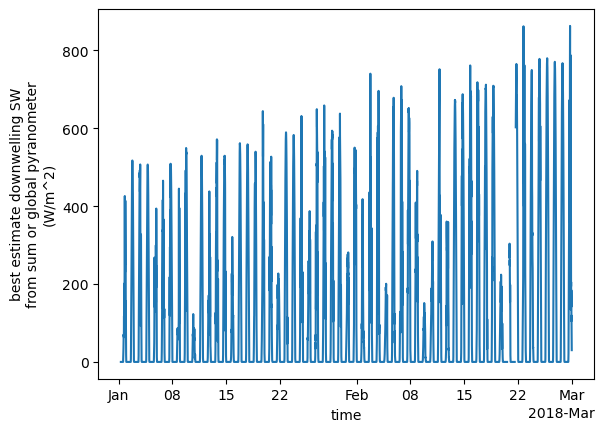

In [165]:
ds.shortwave_down_best_estimate.plot()

In [79]:
ds = ds.sel(time = slice(pd.to_datetime('20180101'),pd.to_datetime('20180301')))

In [166]:
# Parameters
window_days = 1 #30
dt_minutes = 10
samples_per_year = 24 * (60 // dt_minutes) * 365  # ~35000 per year

window_len = window_days * 24 * (60 // dt_minutes)  # number of time steps in window

In [167]:
target_var = target_vars[11]
target_var

'cloud_OD'

In [168]:
# Select and stack inputs
X_raw = ds[input_vars].to_array().transpose('time', 'variable').values  # shape (time, features)
y_raw = ds[target_var].values                                           # shape (time,)

In [169]:
from numpy.lib.stride_tricks import sliding_window_view

In [170]:
# Step 1: sliding window over time axis
X_win = sliding_window_view(X_raw, window_shape=(window_len, X_raw.shape[1]))  # shape: (n_samples, 1, window_len, n_features)
X_win = X_win.squeeze(axis=1)  # Now shape = (n_samples, window_len, n_features)

# Step 2: align target
y_win = y_raw[window_len - 1:]  # same number of samples as X_win

# Step 3: mask out NaNs
mask = ~np.isnan(X_win).any(axis=(1, 2)) & ~np.isnan(y_win)
X_win = X_win[mask]
y_win = y_win[mask]

In [171]:
if 0:
    # save
    np.savez_compressed("radflux_data.npz", X=X_win, y=y_win)
    # load
    data = np.load("radflux_data.npz")
    X_win = data['X']
    y_win = data['y']


In [172]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np

# --- Dataset ---
class RADFLUXDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Model ---
class CNNLSTMModel(nn.Module):
    def __init__(self, n_features, time_steps, conv_out_channels=64, lstm_hidden=64):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features,
                               out_channels=conv_out_channels,
                               kernel_size=7,
                               padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)

        pooled_time_steps = time_steps // 4
        self.lstm = nn.LSTM(input_size=conv_out_channels,
                            hidden_size=lstm_hidden,
                            num_layers=1,
                            batch_first=True)

        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)          # (batch, features, time)
        x = self.relu(self.conv1(x))   # (batch, conv_out, time)
        x = self.pool(x)               # (batch, conv_out, time//4)
        x = x.permute(0, 2, 1)         # (batch, time//4, conv_out)
        x, _ = self.lstm(x)            # (batch, time//4, lstm_hidden)
        x = x[:, -1, :]                # last time step
        x = self.fc(x)                 # (batch, 1)
        return x.squeeze(1)            # (batch,)

# # --- Load your preprocessed data ---
# data = np.load("radflux_data.npz")
# X_win = data['X']  # shape: (samples, time_steps, features)
# y_win = data['y']

# --- Create datasets ---
dataset = RADFLUXDataset(X_win, y_win)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- Initialize model ---
n_features = X_win.shape[2]
time_steps = X_win.shape[1]
model = CNNLSTMModel(n_features, time_steps)

# --- Training setup ---
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
patience = 10
best_val_loss = float('inf')
wait = 0

# --- Training loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_preds = model(X_val)
            val_loss += loss_fn(val_preds, y_val).item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | best Val Loss: {best_val_loss} | wait: {wait}/{patience}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), "best_radflux_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/100 | Train Loss: 2252.4189 | Val Loss: 1815.7803 | best Val Loss: inf | wait: 0/10
Epoch 2/100 | Train Loss: 2377.7327 | Val Loss: 1797.4869 | best Val Loss: 1815.7803141276042 | wait: 0/10
Epoch 3/100 | Train Loss: 2300.7757 | Val Loss: 1778.2574 | best Val Loss: 1797.4868977864583 | wait: 0/10
Epoch 4/100 | Train Loss: 2318.7869 | Val Loss: 1767.0883 | best Val Loss: 1778.2573852539062 | wait: 0/10
Epoch 5/100 | Train Loss: 2234.2742 | Val Loss: 1755.9931 | best Val Loss: 1767.0883382161458 | wait: 0/10
Epoch 6/100 | Train Loss: 2248.8419 | Val Loss: 1745.0327 | best Val Loss: 1755.9931335449219 | wait: 0/10
Epoch 7/100 | Train Loss: 2193.9198 | Val Loss: 1734.2918 | best Val Loss: 1745.032735188802 | wait: 0/10
Epoch 8/100 | Train Loss: 2150.4566 | Val Loss: 1724.5080 | best Val Loss: 1734.291768391927 | wait: 0/10
Epoch 9/100 | Train Loss: 2148.6831 | Val Loss: 1715.2907 | best Val Loss: 1724.5080057779949 | wait: 0/10
Epoch 10/100 | Train Loss: 2166.9990 | Val Loss: 1706.